In [2]:
from goes_rgb.reader import open_goes_file, get_radiance_array
from goes_rgb.visualization import plot_radiance
from datetime import datetime
from goes_rgb.aws_interface import *

In [3]:
download_goes_files_for_datetime(datetime(2023, 8, 8, 18),channels=["C01","C02","C03"])

['data/OR_ABI-L1b-RadC-M6C01_G16_s20232201801171_e20232201803544_c20232201803599.nc',
 'data/OR_ABI-L1b-RadC-M6C02_G16_s20232201801171_e20232201803544_c20232201803574.nc',
 'data/OR_ABI-L1b-RadC-M6C03_G16_s20232201801171_e20232201803544_c20232201803590.nc']

In [4]:
import glob

# Buscar todos los archivos NetCDF en data/
archivos = glob.glob("data/*.nc")
archivos = archivos[:3]
archivos
# if not archivos:
#     print("No se encontraron archivos en la carpeta data/")
# else:
#     for path in archivos:
#         print(f"Visualizando: {path}")
#         try:
#             ds = open_goes_file(path)
#             rad = get_radiance_array(ds)
#             plot_radiance(rad, titulo=path.split("/")[-1])
#         except Exception as e:
#             print(f"Error al procesar {path}: {e}")


['data/OR_ABI-L1b-RadC-M6C01_G16_s20232201801171_e20232201803544_c20232201803599.nc',
 'data/OR_ABI-L1b-RadC-M6C02_G16_s20232201801171_e20232201803544_c20232201803574.nc',
 'data/OR_ABI-L1b-RadC-M6C03_G16_s20232201801171_e20232201803544_c20232201803590.nc']

In [5]:
#vamos a armar ahora una imagen RGB, para eso guardamos los datos de cada canal en un array 
datasets = []

for path in archivos:
    try:
        ds = open_goes_file(path)
        datasets.append(ds)
    except Exception as e:
        print(f"Error al procesar {path}: {e}")

In [6]:
import numpy as np

print(type((datasets[0])["Rad"]))
print((type(get_radiance_array(datasets[0]))))
print((get_radiance_array(datasets[0])).shape)
(filas, columnas) = (get_radiance_array(datasets[0])).shape
rgb_img = np.zeros((filas, columnas, 3), dtype=np.float32)


<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>
(3000, 5000)


In [32]:
from scipy.ndimage import zoom

# problema: la banda 2 no es igual a las otras dos bandas 
print(type((datasets[1])["Rad"]))
print((type(get_radiance_array(datasets[1]))))
print((get_radiance_array(datasets[1])).shape)
(filas, columnas) = (get_radiance_array(datasets[1])).shape
#rgb_img = np.zeros((filas, columnas, 3), dtype=np.float32)

#solucion: la reescalamos al mismo tamaño de la banda 1   
banda_azul = get_radiance_array(datasets[0])
banda_roja = get_radiance_array(datasets[1])
banda_veggie = get_radiance_array(datasets[2])

# Calcular el factor de escala
factor_x = banda_azul.shape[0] / banda_roja.shape[0]
factor_y = banda_azul.shape[1] / banda_roja.shape[1]

# Reescalar la banda roja
banda_roja_no_nan = np.nan_to_num(banda_roja, nan=0)
banda_roja_reshape = zoom(banda_roja_no_nan, (factor_x, factor_y))

print(banda_roja_reshape.shape)
type(banda_roja_reshape)
np.unique(banda_roja_reshape)
print(factor_x, factor_y)


<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>
(6000, 10000)
(3000, 5000)
0.5 0.5


In [29]:
print(np.isnan(banda_roja).all())  # ¿Es todo NaN?
print(np.nanmin(banda_roja), np.nanmax(banda_roja))  # ¿Hay algún valor válido?

False
-20.289911 628.98724


In [33]:
print(np.isnan(banda_roja_reshape).all())  # ¿Es todo NaN?
print(np.nanmin(banda_roja_reshape), np.nanmax(banda_roja_reshape))  # ¿Hay algún valor válido?

False
-51.119835 699.586


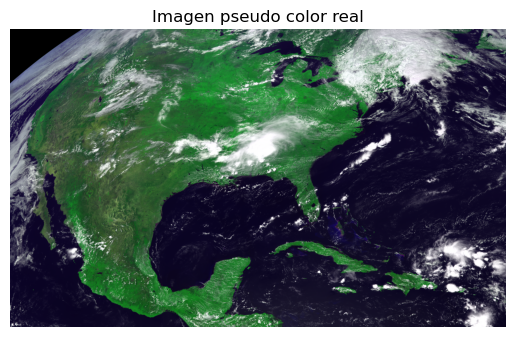

In [37]:
def normalizar(banda):
    banda = np.nan_to_num(banda)  # reemplaza NaNs por 0
    min_val = np.percentile(banda, 1)
    max_val = np.percentile(banda, 99)
    return np.clip((banda - min_val) / (max_val - min_val), 0, 1)

# Normalizar las bandas
banda_azul = normalizar(banda_azul)
banda_roja_reshape = normalizar(banda_roja_reshape)
banda_veggie = normalizar(banda_veggie)
# Crear la imagen RGB
rgb_img[:, :, 0] = banda_roja_reshape
rgb_img[:, :, 1] = banda_veggie
rgb_img[:, :, 2] = banda_azul
# mostrar la imagen 

import matplotlib.pyplot as plt
plt.imshow(rgb_img)
plt.title("Imagen pseudo color real")
plt.axis("off")
plt.show()

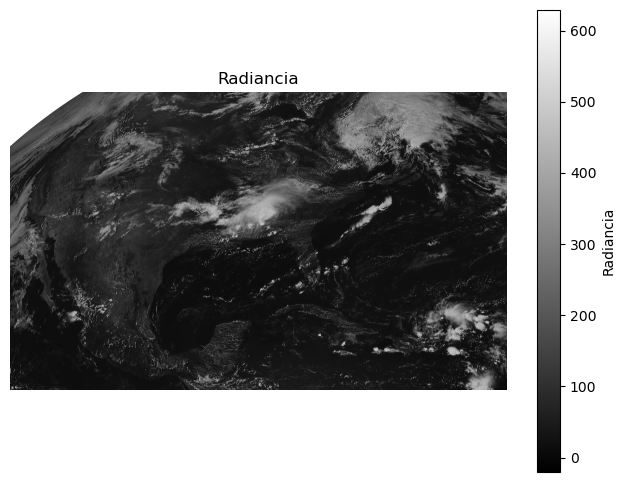

In [12]:
plot_radiance(get_radiance_array(datasets[1]))